In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scs
from yahoofinancials import YahooFinancials
import ray
import os
from timebudget import timebudget
import seaborn as sns
import pickle

C:\Users\Ferhat\Anaconda3\envs\py39\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
from datetime import date
today = date.today()

Dowload or save dataframe from Pickle to minimise API requests

In [17]:
#df.to_pickle('ferhat_portfolio.p')
df = pd.read_pickle('ferhat_portfolio.p')

Download stock data using two different methods

In [12]:
stock = "SMT.L SGLN.L CMCX.L GHH.L 0P00000QW9.L GSK.L RIO.L BATG.L BA.L ROBG.L CSWU.L HMCH.L AAL.L BATS.L IAG.L HTRY.L RR.L KLWD.L 0P00000QWT.L JUP.L HTWN.L PHAG.L CDGP.AQ BOO.L"
stock2 = ['SMT.L', 'SGLN.L', 'CMCX.L', 'GHH.L', '0P00000QW9.L', 'GSK.L', 'RIO.L', 'BATG.L', 'BA.L', 'ROBG.L', 'CSWU.L', 'HMCH.L', 'AAL.L', 'BATS.L', 'IAG.L', 'HTRY.L', 'RR.L', 'KLWD.L', '0P00000QWT.L', 'JUP.L', 'HTWN.L', 'PHAG.L', 'CDGP.AQ', 'BOO.L']

date_start = '2017-01-01'
date_end = today.strftime("%Y-%m-%d")
time_interval = ['daily', 'weekly','monthly'][0]

In [13]:
data = yf.download(stock, start=date_start, end=date_end)

[*********************100%***********************]  24 of 24 completed

1 Failed download:
- CSWU.L: No data found for this date range, symbol may be delisted


In [14]:
data_close = data['Adj Close']

<AxesSubplot:xlabel='Date'>

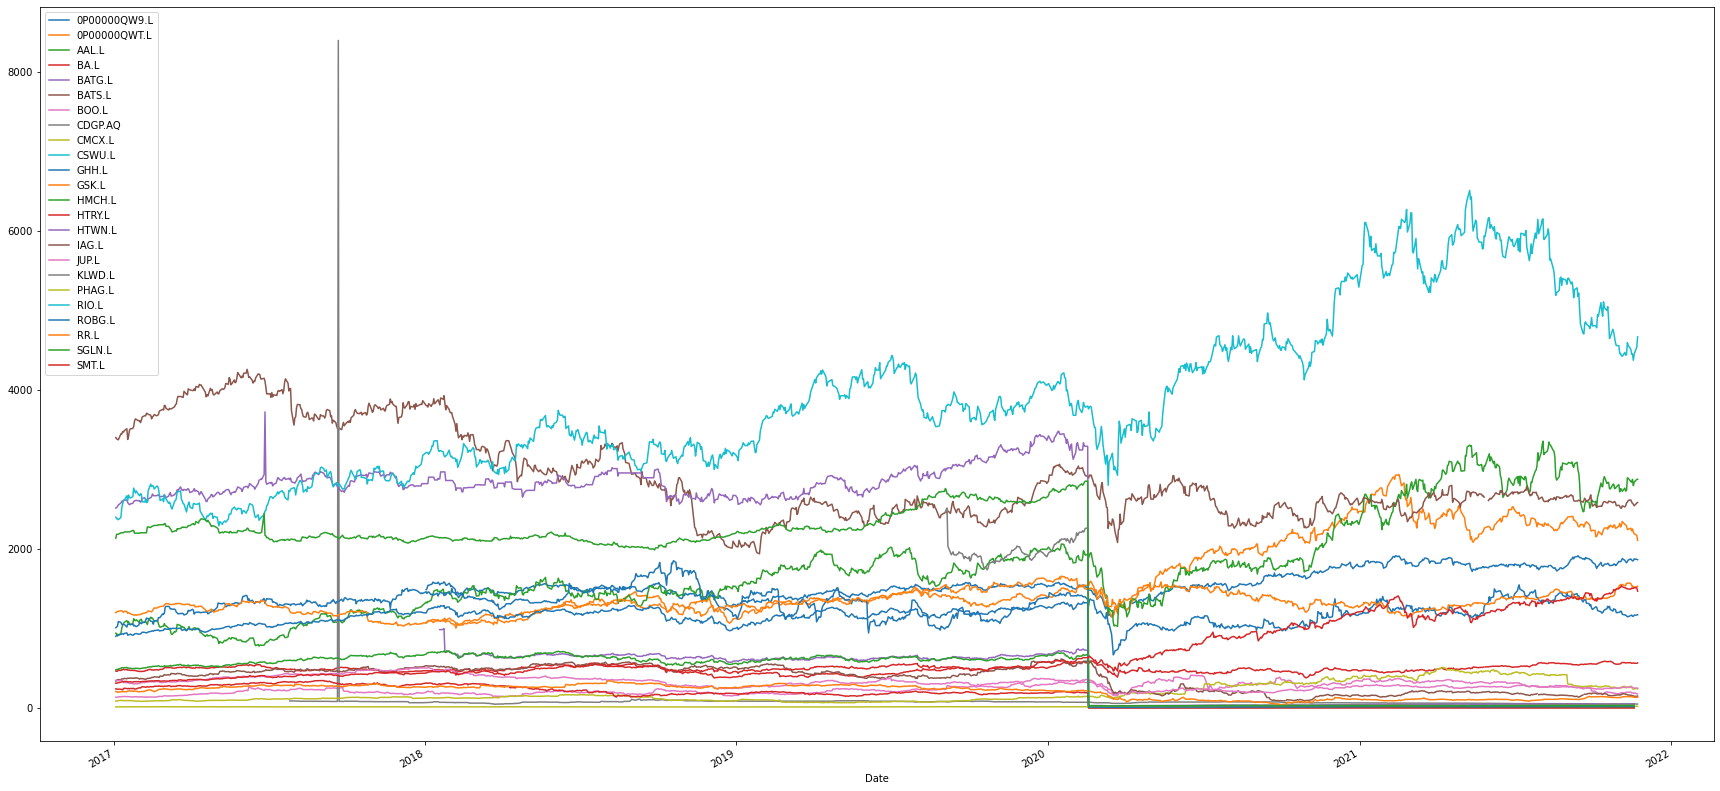

In [15]:
data_close.plot(figsize=(30,15))

Use Moustafa method as in here: https://github.com/msh855/Medium_repo/blob/main/How_to_Download_Stock_prices_faster.ipynb

In [ ]:
@ray.remote
def get_stock_data(ticker, start_date, end_date, time_interval):
    yahoo_financials = YahooFinancials(ticker)
    data = yahoo_financials.get_historical_price_data(start_date= start_date, 
                                                      end_date=end_date, 
                                                      time_interval=time_interval)
    # to get short name and type 
    temp = yahoo_financials.get_stock_quote_type_data()
    
    df_temp = pd.DataFrame(data[ticker]['prices'])
    
    # fix faulty yahoo data that jumps 100x
    #df_temp = df_temp.dropna(subset = ['adjclose'])
    jumps_up   = df_temp['adjclose'] / df_temp['adjclose'].shift() >  50
    jumps_down = df_temp['adjclose'] / df_temp['adjclose'].shift() < .02
    correction_factor = 100.**(jumps_down.cumsum() - jumps_up.cumsum())
    df_temp['adjclose'] *= correction_factor
    
    df_temp['Stock'] = temp[ticker]['shortName']
    df_temp['Type'] = temp[ticker]['quoteType']
    
    # use yahoo finance to get other information 
    tik_info = yf.Ticker(ticker)
    info = tik_info.info
    if "sector" in info:
        df_temp['Sector'] = info["sector"]
    else: 
        df_temp['Sector'] = 'unclassified'
            
    return df_temp


ray.init(ignore_reinit_error=True, num_cpus=2)
@timebudget
def download_my_stocks(operation, input):
    mydata = ray.get([operation.remote(ticker,date_start,date_end, time_interval) for ticker in input]) 
    return mydata

mydata=download_my_stocks(get_stock_data, stock2)
#ray.shutdown()

df = pd.concat(mydata)
df = df.rename(columns={'formatted_date':'Date'})
df = df.drop('date', axis = 1)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')
df.head()

In [8]:
df.tail()

high         low        open       close     volume  \
Date                                                                    
2021-11-15  203.899994  199.300003  202.000000  202.699997  9529979.0   
2021-11-16  204.800003  190.649994  204.800003  191.199997  7080290.0   
2021-11-17  194.300003  188.550003  191.050003  192.000000  5329153.0   
2021-11-18  193.384003  183.800003  192.500000  184.350006  7312798.0   
2021-11-19  191.550003  183.899994  186.100006  191.300003  5134157.0   

              adjclose                    Stock    Type             Sector  
Date                                                                        
2021-11-15  202.699997  BOOHOO GROUP PLC ORD 1P  EQUITY  Consumer Cyclical  
2021-11-16  191.199997  BOOHOO GROUP PLC ORD 1P  EQUITY  Consumer Cyclical  
2021-11-17  192.000000  BOOHOO GROUP PLC ORD 1P  EQUITY  Consumer Cyclical  
2021-11-18  184.350006  BOOHOO GROUP PLC ORD 1P  EQUITY  Consumer Cyclical  
2021-11-19  191.300003  BOOHOO GROUP PLC ORD 1P  EQUITY  Consumer Cyclical

In [ ]:
df = df.reset_index()

Check data in Seaborn Lineplot

(0.0, 10000.0)

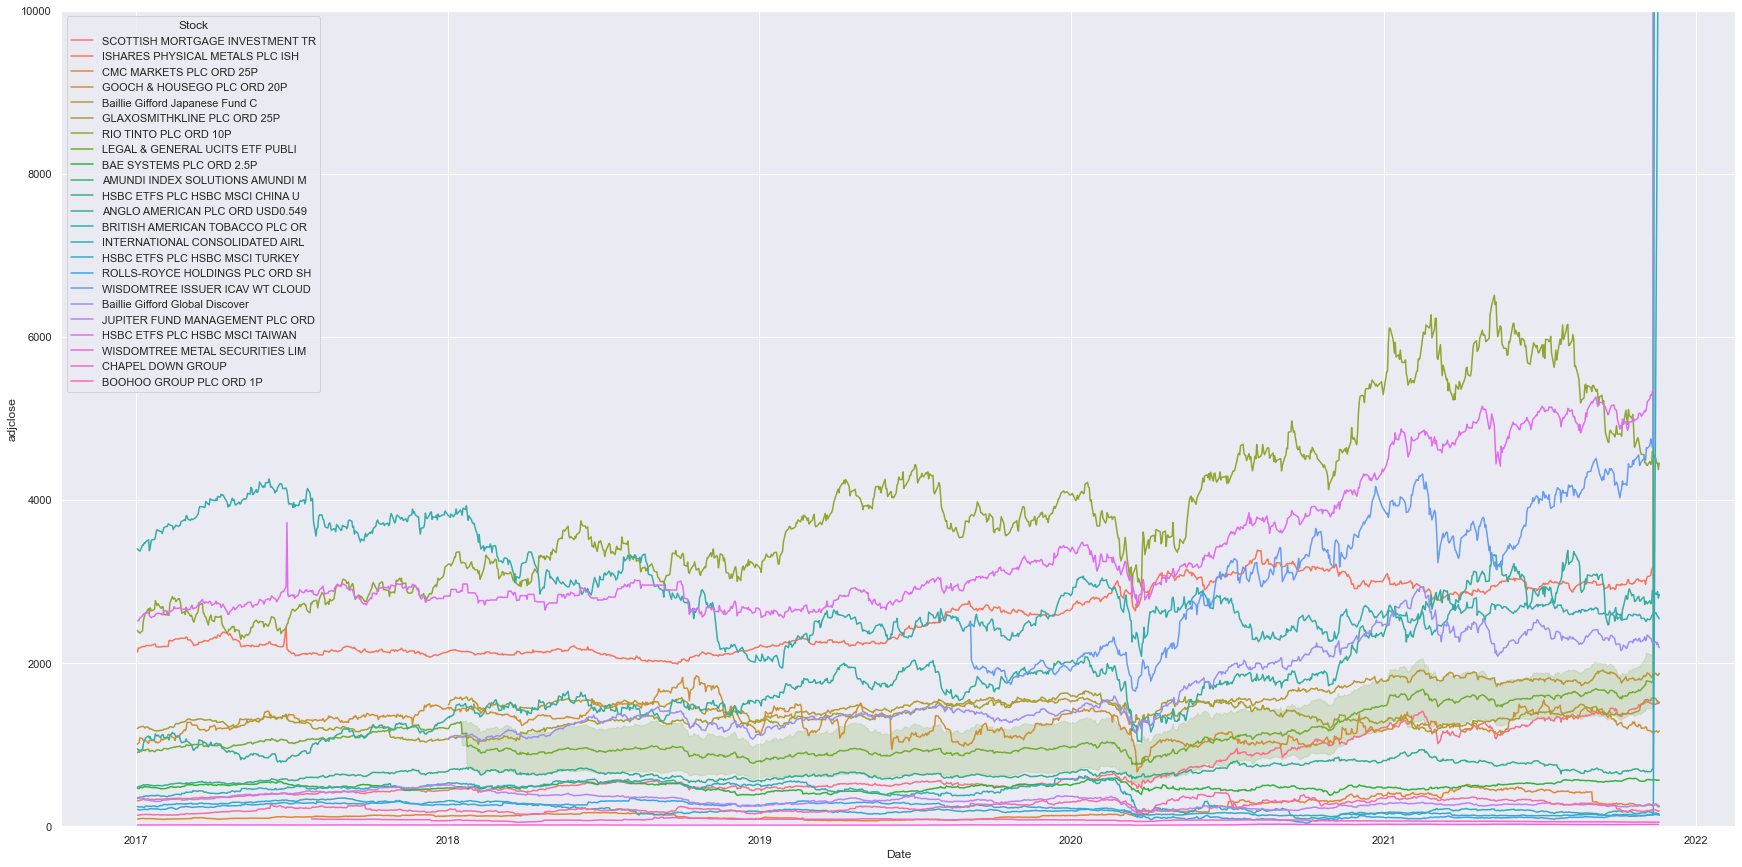

In [18]:
sns.set(rc={'figure.figsize':(30,15)})
sns.lineplot(data = df, x='Date', y='adjclose', hue = 'Stock')
plt.ylim(0, 10000)

Lets try Plotly

In [19]:
import plotly.express as px

fig = px.line(df, x="Date", y="adjclose", color='Stock')
fig.show()

In [20]:
fig = px.scatter(df, x="Date", y="adjclose", facet_col="Stock", facet_col_wrap=4)
fig.update_traces(marker=dict(size=2))
fig.update_yaxes(matches=None)
fig.show()

In [26]:
df.head()

Date        high         low        open       close     volume  \
0 2017-01-03  322.399994  319.427002  322.399994  322.000000  1671071.0   
1 2017-01-04  322.500000  320.600006  322.000000  321.799988  1171663.0   
2 2017-01-05  324.399994  319.500000  319.500000  323.000000  1600422.0   
3 2017-01-06  328.299988  323.100006  323.500000  328.299988  1685091.0   
4 2017-01-09  336.000000  329.100006  329.200012  334.500000  2486622.0   

     adjclose                            Stock    Type        Sector  
0  313.748962  SCOTTISH MORTGAGE INVESTMENT TR  EQUITY  unclassified  
1  313.554016  SCOTTISH MORTGAGE INVESTMENT TR  EQUITY  unclassified  
2  314.723328  SCOTTISH MORTGAGE INVESTMENT TR  EQUITY  unclassified  
3  319.887421  SCOTTISH MORTGAGE INVESTMENT TR  EQUITY  unclassified  
4  325.928558  SCOTTISH MORTGAGE INVESTMENT TR  EQUITY  unclassified

In [33]:
wide = df.pivot_table(index=['Date'], values='adjclose', columns='Stock')

In [35]:
wide.dropna(how='all')

Stock       AMUNDI INDEX SOLUTIONS AMUNDI M  ANGLO AMERICAN PLC ORD USD0.549  \
Date                                                                           
2017-01-03                              NaN                       949.614990   
2017-01-04                              NaN                       933.679077   
2017-01-05                              NaN                       935.722229   
2017-01-06                              NaN                       927.549866   
2017-01-09                              NaN                       943.485718   
...                                     ...                              ...   
2021-11-15                              NaN                      2850.000000   
2021-11-16                              NaN                      2841.500000   
2021-11-17                              NaN                      2877.500000   
2021-11-18                       475.024994                      2798.500000   
2021-11-19                              NaN                      2844.000000   

Stock       BAE SYSTEMS PLC ORD 2.5P  BOOHOO GROUP PLC ORD 1P  \
Date                                                            
2017-01-03                467.504150               137.000000   
2017-01-04                462.757874               134.000000   
2017-01-05                464.735535               138.500000   
2017-01-06                478.578613               140.750000   
2017-01-09                472.645844               143.500000   
...                              ...                      ...   
2021-11-15                570.799988               202.699997   
2021-11-16                563.599976               191.199997   
2021-11-17                565.200012               192.000000   
2021-11-18                568.799988               184.350006   
2021-11-19                565.000000               191.300003   

Stock       BRITISH AMERICAN TOBACCO PLC OR  Baillie Gifford Global Discover  \
Date                                                                           
2017-01-03                      3403.592773                              NaN   
2017-01-04                      3388.464111                              NaN   
2017-01-05                      3379.977051                              NaN   
2017-01-06                      3375.549316                              NaN   
2017-01-09                      3450.085449                              NaN   
...                                     ...                              ...   
2021-11-15                      2619.000000                           2263.0   
2021-11-16                      2593.500000                           2229.0   
2021-11-17                      2574.500000                           2254.0   
2021-11-18                      2565.500000                           2213.0   
2021-11-19                      2544.500000                           2192.0   

Stock       Baillie Gifford Japanese Fund C  CHAPEL DOWN GROUP  \
Date                                                             
2017-01-03                              NaN                NaN   
2017-01-04                              NaN                NaN   
2017-01-05                              NaN                NaN   
2017-01-06                              NaN                NaN   
2017-01-09                              NaN                NaN   
...                                     ...                ...   
2021-11-15                           1876.0               51.0   
2021-11-16                           1863.0               51.0   
2021-11-17                           1851.0               51.0   
2021-11-18                           1855.0               51.0   
2021-11-19                           1877.0               51.0   

Stock       CMC MARKETS PLC ORD 25P  GLAXOSMITHKLINE PLC ORD 25P  ...  \
Date                                                              ...   
2017-01-03                88.061180                  1200.208862  .

In [27]:
import pypfopt
pypfopt.__version__

'1.5.1'

In [36]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(wide, frequency=40)
sample_cov

C:\Users\Ferhat\Anaconda3\envs\py39\lib\site-packages\pypfopt\risk_models.py:68: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.



LinAlgError: Eigenvalues did not converge

In [37]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(wide)
mu

Stock
AMUNDI INDEX SOLUTIONS AMUNDI M          NaN
ANGLO AMERICAN PLC ORD USD0.549     0.021303
BAE SYSTEMS PLC ORD 2.5P            0.019904
BOOHOO GROUP PLC ORD 1P             0.022334
BRITISH AMERICAN TOBACCO PLC OR     0.019799
Baillie Gifford Global Discover     0.019566
Baillie Gifford Japanese Fund C     0.020946
CHAPEL DOWN GROUP                   0.020096
CMC MARKETS PLC ORD 25P             0.020481
GLAXOSMITHKLINE PLC ORD 25P         0.020483
GOOCH & HOUSEGO PLC ORD 20P         0.020870
HSBC ETFS PLC HSBC MSCI CHINA U     5.016634
HSBC ETFS PLC HSBC MSCI TAIWAN      0.020207
HSBC ETFS PLC HSBC MSCI TURKEY      4.981256
INTERNATIONAL CONSOLIDATED AIRL     0.018600
ISHARES PHYSICAL METALS PLC ISH     4.387607
JUPITER FUND MANAGEMENT PLC ORD     0.019029
LEGAL & GENERAL UCITS ETF PUBLI     5.145286
RIO TINTO PLC ORD 10P               0.021269
ROLLS-ROYCE HOLDINGS PLC ORD SH     0.018545
SCOTTISH MORTGAGE INVESTMENT TR     0.020665
WISDOMTREE ISSUER ICAV WT CLOUD    11.093369
WISD

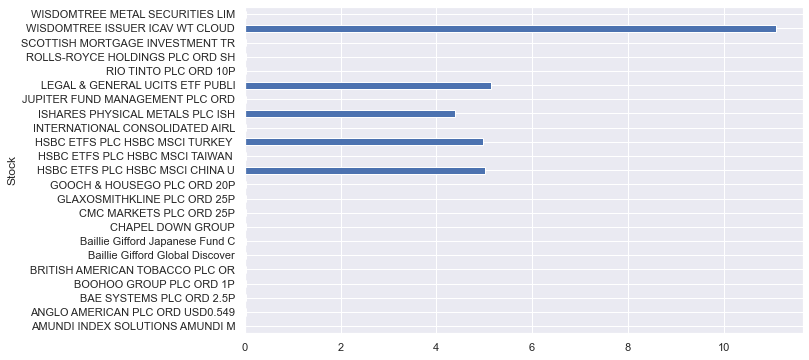

In [38]:
mu.plot.barh(figsize=(10,6));

In [39]:
from pypfopt import EfficientFrontier

In [40]:
S = risk_models.CovarianceShrinkage(wide).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AMUNDI INDEX SOLUTIONS AMUNDI M', 0.04348),
             ('ANGLO AMERICAN PLC ORD USD0.549', 0.04348),
             ('BAE SYSTEMS PLC ORD 2.5P', 0.04348),
             ('BOOHOO GROUP PLC ORD 1P', 0.04348),
             ('BRITISH AMERICAN TOBACCO PLC OR', 0.04348),
             ('Baillie Gifford Global Discover', 0.04348),
             ('Baillie Gifford Japanese Fund C', 0.04348),
             ('CHAPEL DOWN GROUP', 0.04348),
             ('CMC MARKETS PLC ORD 25P', 0.04348),
             ('GLAXOSMITHKLINE PLC ORD 25P', 0.04348),
             ('GOOCH & HOUSEGO PLC ORD 20P', 0.04348),
             ('HSBC ETFS PLC HSBC MSCI CHINA U', 0.04348),
             ('HSBC ETFS PLC HSBC MSCI TAIWAN ', 0.04348),
             ('HSBC ETFS PLC HSBC MSCI TURKEY ', 0.04348),
             ('INTERNATIONAL CONSOLIDATED AIRL', 0.04348),
             ('ISHARES PHYSICAL METALS PLC ISH', 0.04348),
             ('JUPITER FUND MANAGEMENT PLC ORD', 0.04348),
             ('LEGAL & GENERAL UCITS ETF P

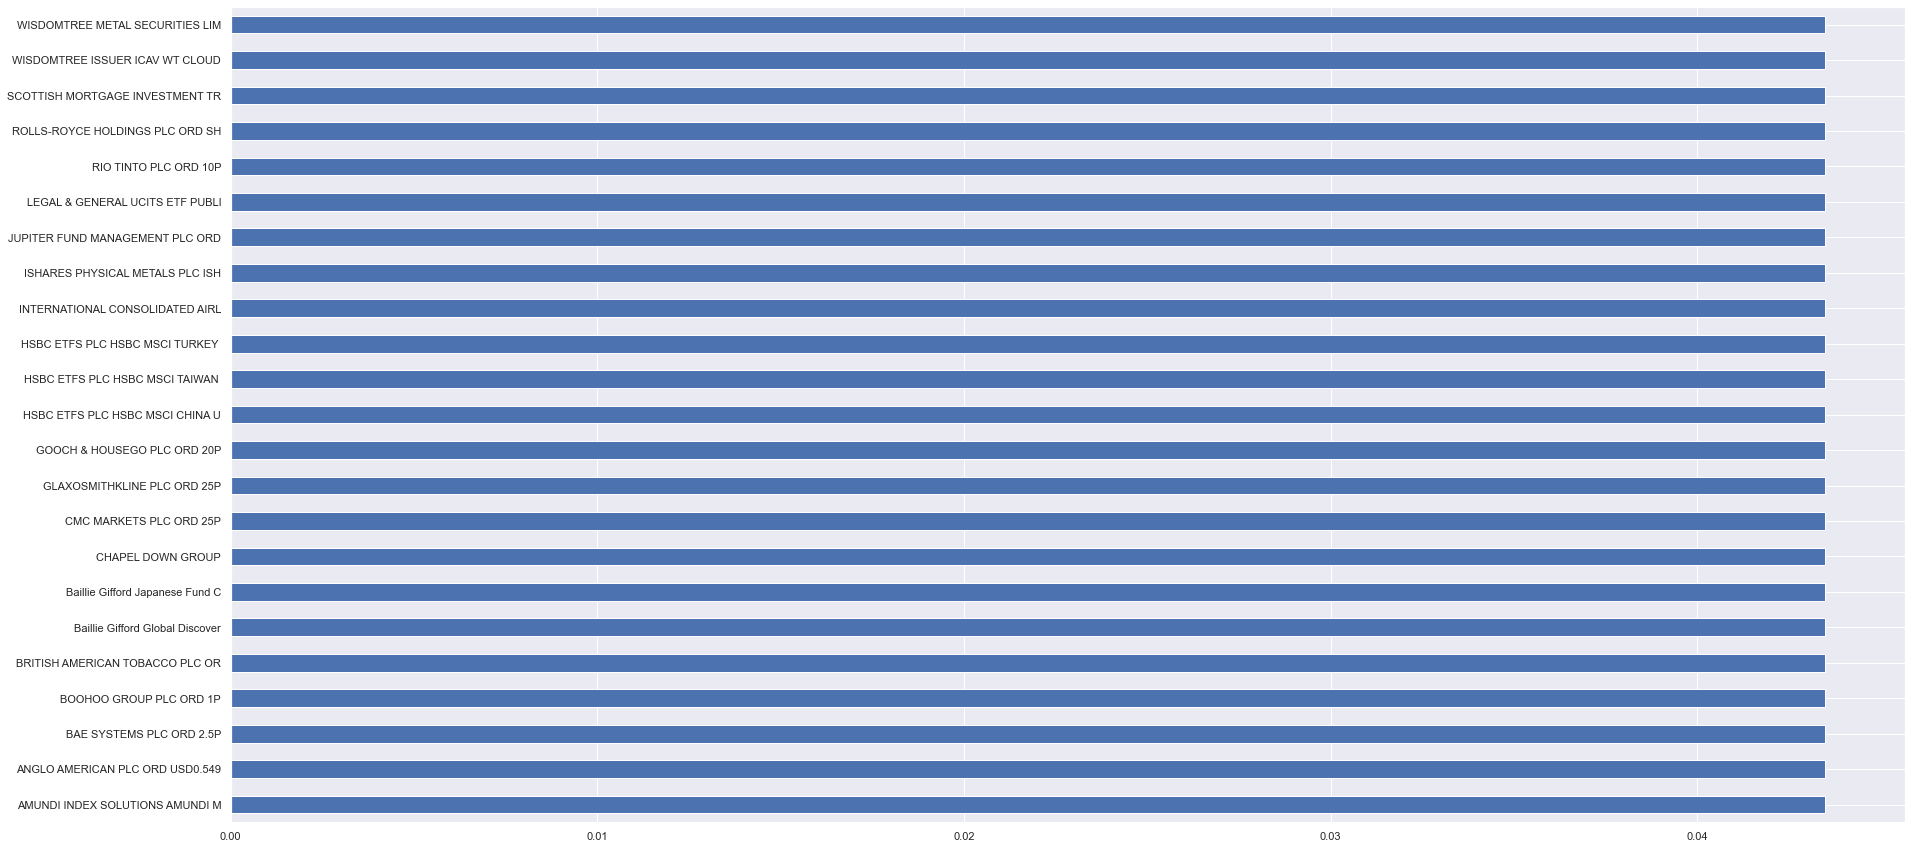

In [41]:
pd.Series(weights).plot.barh();

In [42]:
ef.portfolio_performance(verbose=True);

Annual volatility: 413.5%


In [43]:
from pypfopt import DiscreteAllocation

latest_prices = wide.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

TypeError: latest_prices should be a pd.Series with no NaNs

In [45]:
data.tail()

Adj Close                                           \
                    0P00000QW9.L 0P00000QWT.L   AAL.L        BA.L  BATG.L   
Date                                                                        
2021-11-17 00:00:00       1851.0       2254.0  2877.5  565.200012  14.351   
2021-11-18 00:00:00       1855.0       2213.0  2798.5  568.799988  14.330   
2021-11-19 00:00:00       1877.0       2192.0  2844.0  565.000000  14.309   
2021-11-22 00:00:00       1871.0       2175.0  2876.0  563.799988     NaN   
2021-11-23 00:00:00       1867.0       2111.0  2879.0  568.599976     NaN   

                                                               ...  Volume  \
                     BATS.L       BOO.L CDGP.AQ CMCX.L CSWU.L  ...  HTWN.L   
Date                                                           ...           
2021-11-17 00:00:00  2574.5  192.000000    51.0  243.0    NaN  ...   291.0   
2021-11-18 00:00:00  2565.5  184.350006    51.0  239.5    NaN  ...  5148.0   
2021-11-19 00:00:00  2544.5  191.300003    51.0  241.0    NaN  ...   279.0   
2021-11-22 00:00:00  2579.5  180.300003    51.0  248.0    NaN  ...     NaN   
2021-11-23 00:00:00  2586.0  178.649994    51.0  241.0    NaN  ...     NaN   

                                                                             \
                          IAG.L    JUP.L   KLWD.L  PHAG.L    RIO.L   ROBG.L   
Date                                                                          
2021-11-17 00:00:00  46384424.0  1492593   2671.0   28410  2790823  28798.0   
2021-11-18 00:00:00  21688069.0  3776280   5690.0   34309  2460322   8300.0   
2021-11-19 00:00:00  65329541.0  3669493  11957.0   40050  3569603  25539.0   
2021-11-22 00:00:00  31621765.0   571349      NaN  106857  3419280      NaN   
2021-11-23 00:00:00  21092685.0   632679      NaN  314453  4603125      NaN   

                                                   
                           RR.L   SGLN.L    SMT.L  
Date                                               
2021-11-17 00:00:00  19933194.0  96585.0  3193506  
2021-11-18 00:00:00  17084798.0  75315.0  4523963  
2021-11-19 00:00:00  74157325.0  81430.0  3508284  
2021-11-22 00:00:00  26956818.0      NaN  4590918  
2021-11-23 00:00:00  17563491.0      NaN  3481778  

[5 rows x 144 columns]

In [2]:
pip install investpy

  Created wheel for investpy: filename=investpy-1.0.7-py3-none-any.whl size=4495221 sha256=4c78d738afffc3047111f3d9a5bbacf75c8cad4882684883d9289f56df56d7b5
  Stored in directory: c:\users\ferhat\appdata\local\pip\cache\wheels\b5\d8\cf\e605ca1f39c3a8aa6ea6dc9e8cf9c8f741f8019119e4575696
Successfully built investpy
Note: you may need to restart the kernel to use updated packages.


In [3]:
import investpy

df = investpy.get_stock_historical_data(stock='AAPL',
                                        country='United States',
                                        from_date='01/01/2010',
                                        to_date='01/01/2020')
print(df.head())

            Open  High   Low  Close     Volume Currency
Date                                                   
2010-01-04  7.62  7.66  7.58   7.64  493728704      USD
2010-01-05  7.66  7.70  7.62   7.66  601904640      USD
2010-01-06  7.66  7.69  7.53   7.53  552158912      USD
2010-01-07  7.56  7.57  7.47   7.52  477129760      USD
2010-01-08  7.51  7.57  7.47   7.57  447876768      USD


In [11]:
df = investpy.get_stock_historical_data(stock='46134',
                                        country = 'Germany',
                                        from_date='01/01/2010',
                                        to_date='01/01/2020')

RuntimeError: ERR#0018: stock 46134 not found, check if it is correct.